
Beale: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Beale'
n_test = 500
eps = 1e-08

util = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3


In [4]:
### Objective Function - Beale(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2 
                )
       
# Constraints:
lb = -4.5
ub = +4.5

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_lb = 0 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds

In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]
    
    def CBM(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, y_global_orig, mean, std, ds, dm, nu=3.0):
    
        return self.f(y_global_orig, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):
    
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. ExactAcqFunc \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
            min_acqfunc_exact = BOLD + OKGREEN + min_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc_exact, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

n_start = n_start_AcqFunc

class dGPGO(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. ExactAcqFunc \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B'):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
            min_acqfunc_approx = BOLD + OKGREEN + min_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc, min_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_15 = 15


***Explanation:*** Why does optimising negative EI with exact (negative) EI gradients, outperform approximate (negative) EI gradients for (negative) EI optimisation?


1. Considering the best (**x**, *y*) point sampled by the exact (negative) EI gradients' model



In [12]:
### ESTIMATED STP CBM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.5         0.95252656]	 20.521410349011653	 20.521410349011653	 -4099.493155313917	 -4102.184585183122


In [13]:
### EXACT STP CBM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.2231993   1.25540485]	 2.484096500444409	 2.484096500444409	 -4099.493155313917	 -4102.184585183122


In [14]:
approx_15.start_points_arr


array([[ 4.00534575, -3.51498016],
       [-0.31416155, -3.22600266],
       [ 0.34513886, -1.80901209],
       [ 0.33970697,  1.49064784],
       [-1.22104079,  1.10716757],
       [ 1.28452397, -0.72016362],
       [-0.87081809, -0.98621707],
       [-0.8442943 , -3.78300505],
       [-3.98851919, -3.79502182],
       [ 1.7611003 , -4.23756935],
       [-0.00456822, -3.30629114],
       [-4.2231993 ,  1.25540485],
       [-0.48601667,  4.27145972],
       [-1.53210661, -2.74117659],
       [ 1.65641591, -1.34011028],
       [ 2.43932502,  2.62619551],
       [-0.5051287 , -2.08054529],
       [-4.2848602 , -1.15800691],
       [-3.62042208,  2.04770294],
       [-0.36500017,  0.18446827]])

In [15]:
exact_15.start_points_arr


array([[ 4.00534575, -3.51498016],
       [-0.31416155, -3.22600266],
       [ 0.34513886, -1.80901209],
       [ 0.33970697,  1.49064784],
       [-1.22104079,  1.10716757],
       [ 1.28452397, -0.72016362],
       [-0.87081809, -0.98621707],
       [-0.8442943 , -3.78300505],
       [-3.98851919, -3.79502182],
       [ 1.7611003 , -4.23756935],
       [-0.00456822, -3.30629114],
       [-4.2231993 ,  1.25540485],
       [-0.48601667,  4.27145972],
       [-1.53210661, -2.74117659],
       [ 1.65641591, -1.34011028],
       [ 2.43932502,  2.62619551],
       [-0.5051287 , -2.08054529],
       [-4.2848602 , -1.15800691],
       [-3.62042208,  2.04770294],
       [-0.36500017,  0.18446827]])

In [16]:
np.sum((exact_15.start_points_arr - approx_15.start_points_arr)**2)


0.0

In [17]:
np.round(approx_15.f_best, 5), np.argmin(approx_15.f_best)


(array([-3735.16987, -4095.18935, -4097.57423, -4097.57431, -4097.57434,
        -4097.57423, -4097.57434, -4095.18935, -4036.72298, -4036.72298,
        -4095.18935, -4102.18459, -4097.57433, -4095.18935, -4097.57423,
        -4097.57433, -4095.18935, -4097.57423, -4097.57423, -4097.57433]), 11)

In [18]:
min(approx_15.f_best), np.round(max(approx_15.f_best), 4)


(-4102.184585183122, -3735.1699)

In [19]:
approx_15.x_best[np.argmin(approx_15.f_best)], approx_15.best


(array([-4.5       ,  0.95252656]), array([-4.5       ,  0.95252656]))

In [20]:
np.round(exact_15.f_best, 5), np.argmin(exact_15.f_best)


(array([-4097.57434, -4076.83437, -4057.11286, -4097.57433, -4097.57434,
        -4097.57434, -4097.57434, -4081.36144, -4036.72298, -4036.72298,
        -4080.35236, -4099.49316, -4097.57433, -4036.72298, -4097.57434,
        -4097.57365, -4097.57434, -4036.72298, -4097.57433, -4097.57434]), 11)

In [21]:
min(exact_15.f_best), np.round(max(exact_15.f_best), 4)


(-4099.493155313917, -4036.723)

In [22]:
exact_15.x_best[np.argmin(exact_15.f_best)], exact_15.best


(array([-4.2231993 ,  1.25540485]), array([-4.2231993 ,  1.25540485]))

In [23]:
np.sum((exact_15.f_best - approx_15.f_best)**2)


140856.49610622475

In [24]:
exact_15.x_best


array([[ 4.5       ,  4.5       ],
       [-0.31416155, -3.22600266],
       [ 0.24502716, -1.86461408],
       [ 2.90298083,  4.05392169],
       [ 4.5       ,  4.5       ],
       [ 4.5       ,  4.5       ],
       [ 4.5       ,  4.5       ],
       [-0.8442943 , -3.78300505],
       [-4.5       , -4.5       ],
       [-4.5       , -4.5       ],
       [-0.49172351, -3.43564948],
       [-4.2231993 ,  1.25540485],
       [ 1.53922466,  4.5       ],
       [-4.5       , -4.5       ],
       [ 4.5       ,  4.5       ],
       [ 2.44103415,  2.62790464],
       [ 4.5       ,  4.5       ],
       [-4.5       , -4.5       ],
       [ 1.51120428,  4.5       ],
       [ 4.5       ,  4.5       ]])

In [25]:
np.sum((exact_15.x_best - exact_15.start_points_arr)**2)


471.1546674212693

In [26]:
approx_15.x_best


array([[ 4.5       , -4.5       ],
       [-0.53439898, -4.5       ],
       [-4.5       ,  4.5       ],
       [ 3.64963105,  3.22905604],
       [ 4.5       ,  4.5       ],
       [-4.5       ,  4.5       ],
       [ 4.5       ,  4.5       ],
       [-0.53439677, -4.5       ],
       [-4.5       , -4.5       ],
       [-4.5       , -4.5       ],
       [-0.53439588, -4.5       ],
       [-4.5       ,  0.95252656],
       [ 1.35396586,  4.5       ],
       [-0.53439576, -4.5       ],
       [-4.5       ,  4.5       ],
       [ 2.57036775,  3.47015933],
       [-0.5343999 , -4.5       ],
       [-4.5       ,  4.5       ],
       [-4.5       ,  4.5       ],
       [ 4.5       ,  3.34769265]])

In [27]:
np.sum((approx_15.x_best - approx_15.start_points_arr)**2)


445.19290299183774

In [28]:
np.sum((exact_15.x_best - approx_15.x_best)**2)


552.1402232886165

In [29]:
a = approx_15.best[0]
b = approx_15.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


20.521410349011653

In [30]:
a = exact_15.best[0]
b = exact_15.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


2.484096500444409

In [31]:
xBest0 = 0.0898
xBest1 = -0.7126

xBest = [xBest0, xBest1]
xBest


[0.0898, -0.7126]

In [32]:
def check(x):
  a = x[:,0]
  b = x[:,1] 
  for i in range(0, len(a) - 1):
    res = (a - xBest0)**2 + (b - xBest1)**2 
    return np.sum(res)

check(approx_15.x_best), check(exact_15.x_best)


(653.1169405965563, 622.1344022144732)

In [33]:
np.std(approx_15.x_best), np.std(exact_15.x_best)


(3.9517742336818285, 3.739414382798411)

In [34]:
np.mean(approx_15.x_best), np.mean(exact_15.x_best)


(-0.05246470108929646, 0.8598513082059611)

In [35]:
approx_15_20rms = pd.Series(np.round(approx_15.f_best, 2)).value_counts(sort=True)
approx_15_20rms_df = pd.DataFrame({'Frequency':approx_15_20rms.values,'STP CBM':approx_15_20rms.index})
approx_15_20rms_df


,Frequency,STP CBM
0,11,-4097.57
1,5,-4095.19
2,2,-4036.72
3,1,-3735.17
4,1,-4102.18


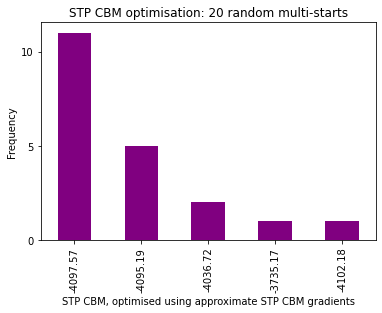

In [36]:
ax = approx_15_20rms.plot.bar(title="STP CBM optimisation: 20 random multi-starts", xlabel="STP CBM, optimised using approximate STP CBM gradients", ylabel="Frequency", color="purple", yticks=[0,5,10])


In [37]:
exact_15_20rms = pd.Series(np.round(exact_15.f_best, 2)).value_counts(sort=True)
exact_15_20rms_df = pd.DataFrame({'Frequency':exact_15_20rms.values,'STP CBM':exact_15_20rms.index})
exact_15_20rms_df


,Frequency,STP CBM
0,11,-4097.57
1,4,-4036.72
2,1,-4076.83
3,1,-4057.11
4,1,-4081.36
5,1,-4080.35
6,1,-4099.49


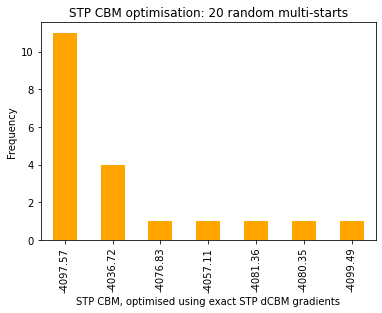

In [38]:
ax = exact_15_20rms.plot.bar(title="STP CBM optimisation: 20 random multi-starts", xlabel="STP CBM, optimised using exact STP dCBM gradients", ylabel="Frequency", color="orange")


In [39]:
n_start = 50


In [40]:
### ESTIMATED STP CBM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_15)
surrogate_approx_15_50rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15_50rms = GPGO_multi(surrogate_approx_15_50rms, Acquisition_grad(util), objfunc, param)
approx_15_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.5         0.95252656]	 20.521410349011653	 20.521410349011653	 -4099.493155313917	 -4102.184585183122


In [41]:
### EXACT STP CBM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_15)
surrogate_exact_15_50rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15_50rms = dGPGO(surrogate_exact_15_50rms, Acquisition_grad(util), objfunc, param)
exact_15_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.2231993   1.25540485]	 2.484096500444409	 2.484096500444409	 -4099.493155313917	 -4102.184585183122


In [42]:
approx_15_50rms = pd.Series(np.round(approx_15_50rms.f_best, 2)).value_counts(sort=True)
approx_15_50rms_df = pd.DataFrame({'Frequency':approx_15_50rms.values,'STP CBM':approx_15_50rms.index})
approx_15_50rms_df


,Frequency,STP CBM
0,34,-4097.57
1,8,-4095.19
2,4,-3735.17
3,3,-4036.72
4,1,-4102.18


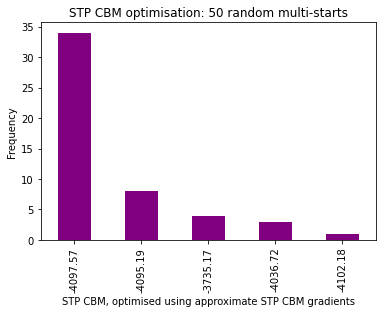

In [43]:
ax = approx_15_50rms.plot.bar(title="STP CBM optimisation: 50 random multi-starts", xlabel="STP CBM, optimised using approximate STP CBM gradients", ylabel="Frequency", color="purple")


In [44]:
exact_15_50rms = pd.Series(np.round(exact_15_50rms.f_best, 2)).value_counts(sort=True)
exact_15_50rms_df = pd.DataFrame({'Frequency':exact_15_50rms.values,'STP CBM':exact_15_50rms.index})
exact_15_50rms_df


,Frequency,STP CBM
0,33,-4097.57
1,10,-4036.72
2,1,-4076.83
3,1,-4057.11
4,1,-4081.36
5,1,-4080.35
6,1,-4099.49
7,1,-4086.66
8,1,-4095.17


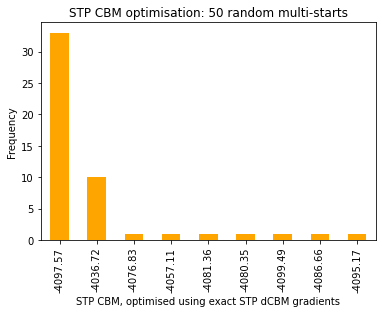

In [45]:
ax = exact_15_50rms.plot.bar(title="STP CBM optimisation: 50 random multi-starts", xlabel="STP CBM, optimised using exact STP dCBM gradients", ylabel="Frequency", color="orange")


In [46]:
n_start = 100


In [47]:
### ESTIMATED STP CBM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_15)
surrogate_approx_15_100rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15_100rms = GPGO_multi(surrogate_approx_15_100rms, Acquisition_grad(util), objfunc, param)
approx_15_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.5         0.95252162]	 20.52210508797569	 20.52210508797569	 -4099.493155313917	 -4102.184585183615


In [48]:
### EXACT STP CBM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_15)
surrogate_exact_15_100rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15_100rms = dGPGO(surrogate_exact_15_100rms, Acquisition_grad(util), objfunc, param)
exact_15_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.2231993   1.25540485]	 2.484096500444409	 2.484096500444409	 -4099.493155313917	 -4102.184585183615


In [49]:
approx_15_100rms = pd.Series(np.round(approx_15_100rms.f_best, 2)).value_counts(sort=True)
approx_15_100rms_df = pd.DataFrame({'Frequency':approx_15_100rms.values,'STP CBM':approx_15_100rms.index})
approx_15_100rms_df


,Frequency,STP CBM
0,69,-4097.57
1,13,-4095.19
2,8,-3735.17
3,8,-4036.72
4,2,-4102.18


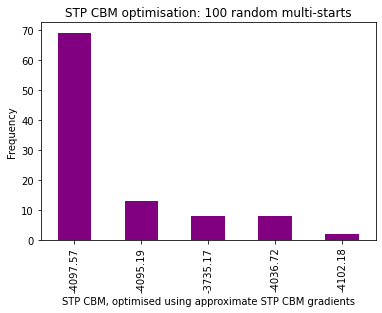

In [50]:
ax = approx_15_100rms.plot.bar(title="STP CBM optimisation: 100 random multi-starts", xlabel="STP CBM, optimised using approximate STP CBM gradients", ylabel="Frequency", color="purple")


In [51]:
exact_15_100rms = pd.Series(np.round(exact_15_100rms.f_best, 2)).value_counts(sort=True)
exact_15_100rms_df = pd.DataFrame({'Frequency':exact_15_100rms.values,'STP CBM':exact_15_100rms.index})
exact_15_100rms_df


,Frequency,STP CBM
0,66,-4097.57
1,21,-4036.72
2,1,-4076.83
3,1,-4057.11
4,1,-4081.36
5,1,-4080.35
6,1,-4099.49
7,1,-4086.66
8,1,-4095.17
9,1,-4073.34


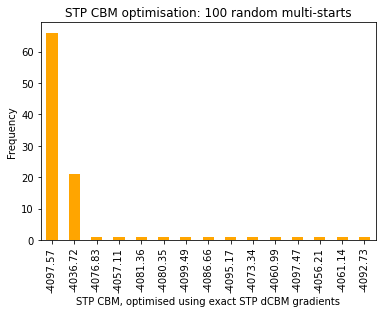

In [52]:
ax = exact_15_100rms.plot.bar(title="STP CBM optimisation: 100 random multi-starts", xlabel="STP CBM, optimised using exact STP dCBM gradients", ylabel="Frequency", color="orange")


In [53]:
print(approx_15_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-4097.57 &  11 \\
-4095.19 &   5 \\
-4036.72 &   2 \\
-3735.17 &   1 \\
-4102.18 &   1 \\
\bottomrule
\end{tabular}



In [54]:
print(exact_15_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-4097.57 &  11 \\
-4036.72 &   4 \\
-4076.83 &   1 \\
-4057.11 &   1 \\
-4081.36 &   1 \\
-4080.35 &   1 \\
-4099.49 &   1 \\
\bottomrule
\end{tabular}



In [55]:
print(approx_15_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-4097.57 &  34 \\
-4095.19 &   8 \\
-3735.17 &   4 \\
-4036.72 &   3 \\
-4102.18 &   1 \\
\bottomrule
\end{tabular}



In [56]:
print(exact_15_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-4097.57 &  33 \\
-4036.72 &  10 \\
-4076.83 &   1 \\
-4057.11 &   1 \\
-4081.36 &   1 \\
-4080.35 &   1 \\
-4099.49 &   1 \\
-4086.66 &   1 \\
-4095.17 &   1 \\
\bottomrule
\end{tabular}



In [57]:
print(approx_15_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-4097.57 &  69 \\
-4095.19 &  13 \\
-3735.17 &   8 \\
-4036.72 &   8 \\
-4102.18 &   2 \\
\bottomrule
\end{tabular}



In [58]:
print(exact_15_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-4097.57 &  66 \\
-4036.72 &  21 \\
-4076.83 &   1 \\
-4057.11 &   1 \\
-4081.36 &   1 \\
-4080.35 &   1 \\
-4099.49 &   1 \\
-4086.66 &   1 \\
-4095.17 &   1 \\
-4073.34 &   1 \\
-4060.99 &   1 \\
-4097.47 &   1 \\
-4056.21 &   1 \\
-4061.14 &   1 \\
-4092.73 &   1 \\
\bottomrule
\end{tabular}

